# Analyse de similarité d’image

Ce projet est une application basée sur Python qui analyse et compare les images en fonction des caractéristiques de couleur. Il calcule les histogrammes de couleur, identifie les couleurs dominantes et mesure la similarité entre les images à l’aide d’un histogramme et de mesures basées sur les couleurs. Les résultats comprennent des visualisations des images les plus similaires, ce qui le rend utile pour le traitement d’image et les applications de récupération d’image basée sur le contenu (CBIR).

### Étape 1 : Charger les images

Charger les images à partir du répertoire spécifié, en indiquant les chemins de toutes les images chargées.

In [1]:
import os

image_dir = '../devoir/DVI1'
image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]


### Étape 2 : Calculer et afficher les histogrammes de couleur

Calcule et affiche les histogrammes de chaque canal de couleur dans chaque image. 


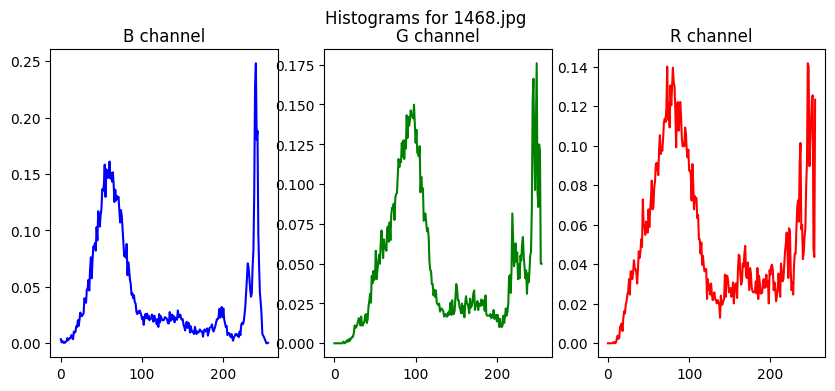

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_color_histogram(image_path):
    img = cv2.imread(image_path)
    chans = cv2.split(img)
    colors = ("b", "g", "r")
    histograms = {}
    
    # Calculate histogram for each color channel
    for (chan, color) in zip(chans, colors):
        hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()  # Normalization
        histograms[color] = hist
    
    return histograms

# histograms calculation 
image_histograms = {path: calculate_color_histogram(path) for path in image_paths}

# Display histograms for the first few images
for i, (path, hist) in enumerate(image_histograms.items()):
    if i >= 1: break  # showing first images
    plt.figure(figsize=(10, 4))
    plt.suptitle(f"Histograms for {os.path.basename(path)}")
    
    for j, color in enumerate(("b", "g", "r")):
        plt.subplot(1, 3, j + 1)
        plt.plot(hist[color], color=color)
        plt.title(f"{color.upper()} channel")
    plt.show()


### Étape 3 : Calculer et afficher les couleurs dominantes

Identifier et afficher les couleurs dominantes pour chaque image en utilisant KMeans clustering.

c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\

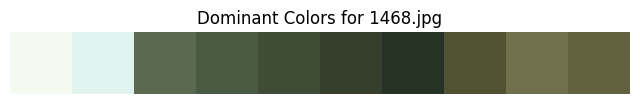

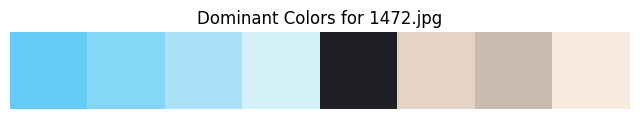

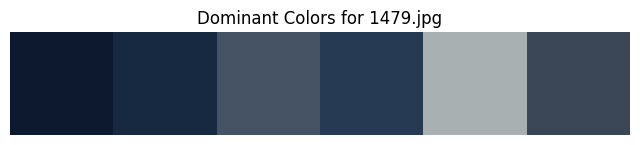

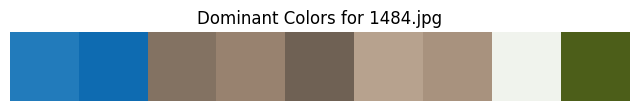

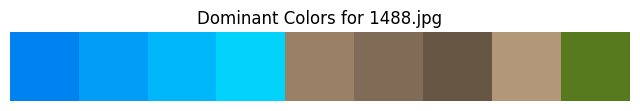

In [5]:
from sklearn.cluster import KMeans
from collections import Counter

def find_dominant_colors(image_path, k=20, threshold=0.05):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.reshape((-1, 3))  # image pixels
    
    # clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(img)
    
    # presence of each clus
    counts = Counter(kmeans.labels_)
    total_pixels = sum(counts.values())
    
    # Extract dominant colors 
    dominant_colors = []
    for idx, count in counts.items():
        if count / total_pixels > threshold:
            dominant_colors.append(kmeans.cluster_centers_[idx])
    
    return np.array(dominant_colors)

# Calculate and display dominant colors for each image
image_dominant_colors = {path: find_dominant_colors(path, k=20) for path in image_paths}

# Display dominant colors for the first few images
for i, (path, colors) in enumerate(image_dominant_colors.items()):
    if i >= 5: break  # showing first 5 images
    plt.figure(figsize=(8, 2))
    plt.title(f"Dominant Colors for {os.path.basename(path)}")
    plt.imshow([colors.astype(int)])
    plt.axis('off')
    plt.show()


### Étape 4 : Calculer les distances de similarité

Calculer les distances par paires entre les images :
- **Distance de l’histogramme** : Basé sur la distance Bhattacharyya entre les histogrammes pour chaque canal de couleur.
- **Distance de couleur dominante** : Basé sur la distance euclidienne entre les ensembles de couleurs dominantes de chaque image.
- **Distance globale** : une métrique normalisée et combinée de l’histogramme et des distances de couleur dominante.

In [10]:
def bhattacharyya_distance(hist1, hist2):
    # Calculate the Bhattacharyya distance between two histograms
    return cv2.compareHist(hist1, hist2, cv2.HISTCMP_BHATTACHARYYA)

from scipy.spatial import distance

def dominant_color_distance(colors1, colors2):
    # Calculate average Euclidean distance between dominant colors of two images
    return distance.cdist(colors1, colors2, 'euclidean').mean()

# To store distances for each metric
histogram_distances = {}
dominant_color_distances = {}

# Calculate pairwise distances
for i, img_path1 in enumerate(image_paths):
    for j, img_path2 in enumerate(image_paths):
        if i < j:
            # Histogram Distance
            hist1 = image_histograms[img_path1]
            hist2 = image_histograms[img_path2]
            histogram_distances[(img_path1, img_path2)] = (
                bhattacharyya_distance(hist1["b"], hist2["b"]) +
                bhattacharyya_distance(hist1["g"], hist2["g"]) +
                bhattacharyya_distance(hist1["r"], hist2["r"])
            )

            # Dominant Color Distance
            colors1 = image_dominant_colors[img_path1]
            colors2 = image_dominant_colors[img_path2]
            dominant_color_distances[(img_path1, img_path2)] = dominant_color_distance(colors1, colors2)

# Normalize and combine distances for a global similarity measure
global_distances = {}
for pair in histogram_distances:
    hist_dist = histogram_distances[pair]
    color_dist = dominant_color_distances[pair]
    
    # Normalize and combine
    global_distances[pair] = (hist_dist / max(histogram_distances.values())) + \
                             (color_dist / max(dominant_color_distances.values()))

# Sort distances for analysis
sorted_histogram = sorted(histogram_distances.items(), key=lambda x: x[1])
sorted_color = sorted(dominant_color_distances.items(), key=lambda x: x[1])
sorted_global = sorted(global_distances.items(), key=lambda x: x[1])


### Étape 5 : Afficher les résultats

Afficher les 5 paires d’images les plus similaires en fonction de chaque mesure de similarité (histogramme, couleurs dominantes, mesure globale) 


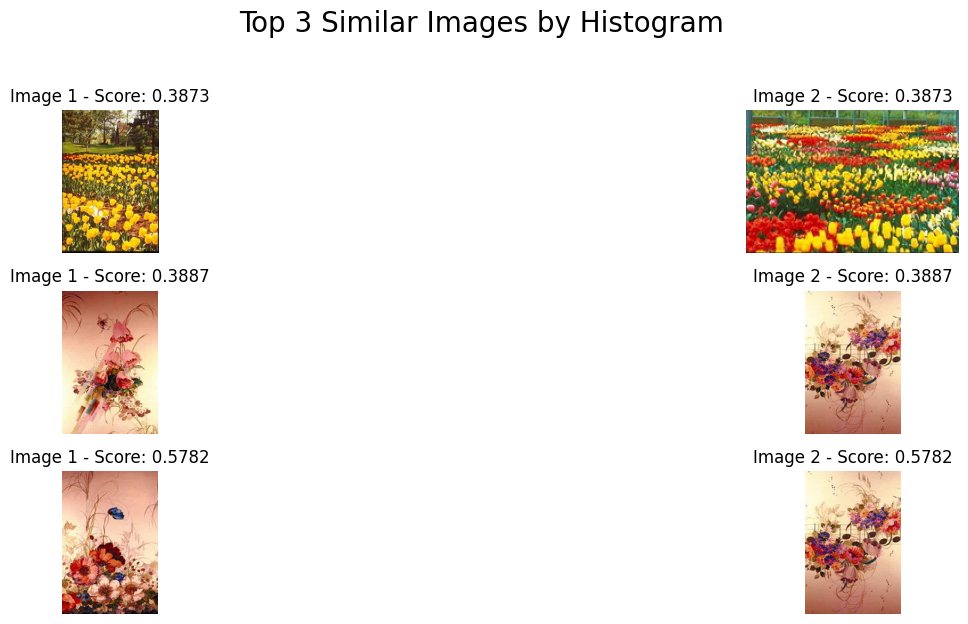

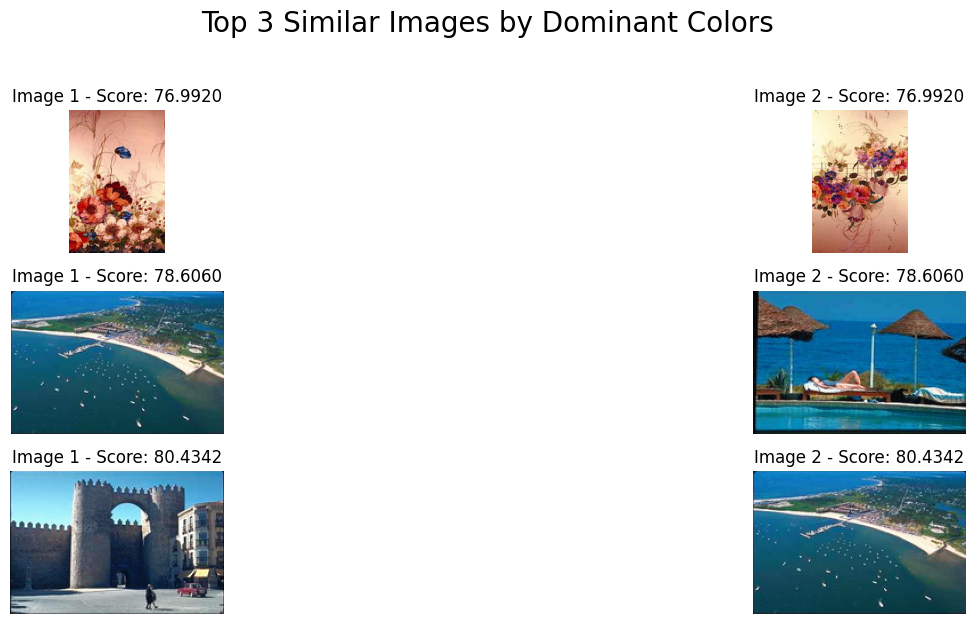

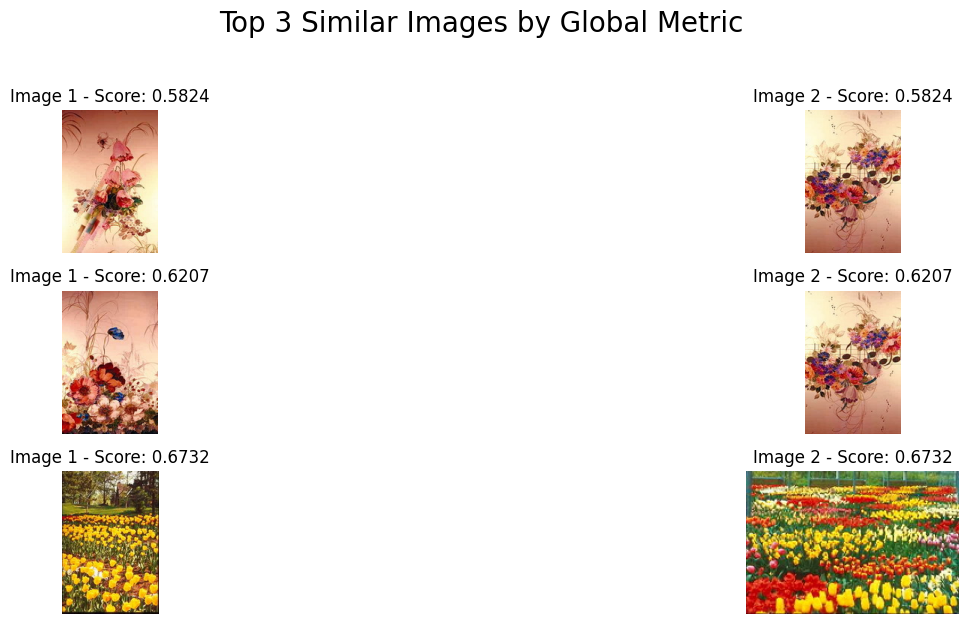

In [11]:
from PIL import Image

def plot_similar_images(similar_pairs, title):
    plt.figure(figsize=(15, 10))
    plt.suptitle(title, fontsize=20)
    
    for i, ((img_path1, img_path2), score) in enumerate(similar_pairs):
        # Load the images
        img1 = Image.open(img_path1)
        img2 = Image.open(img_path2)
        
        # Plot each pair side by side
        plt.subplot(5, 2, 2*i + 1)
        plt.imshow(img1)
        plt.axis('off')
        plt.title(f"Image 1 - Score: {score:.4f}")
        
        plt.subplot(5, 2, 2*i + 2)
        plt.imshow(img2)
        plt.axis('off')
        plt.title(f"Image 2 - Score: {score:.4f}")
        
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Select top 5 similar pairs for each metric
top_3_histogram = sorted_histogram[:3]
top_3_color = sorted_color[:3]
top_3_global = sorted_global[:3]

# Plot results
plot_similar_images(top_3_histogram, "Top 3 Similar Images by Histogram")
plot_similar_images(top_3_color, "Top 3 Similar Images by Dominant Colors")
plot_similar_images(top_3_global, "Top 3 Similar Images by Global Metric")
